# Importing Libraries

## We import the necessary libraries for data processing, visualization, and machine learning models. We also download the NLTK stopwords for text preprocessing.

In [45]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

# For text processing
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Loading and Exploring the Dataset

In [46]:
# Load datasets
train_data = pd.read_csv('/content/train.csv')  # Read the CSV file into a DataFrame
train_data = train_data[['text', 'target']] #select column

test_data = pd.read_csv('test.csv')
# View the first 4 rows of the dataset to understand its structure
train_data.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [47]:
# Check the overall structure and info about the dataset
train_data.info()  # To get information about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


In [48]:
# Check for missing values
train_data.isnull().sum()

,0
text,0
target,0


In [49]:
#Check for duplicate record
train_data.duplicated().sum()

92

In [50]:
# Remove duplicate entries to avoid training the model on repetitive data
train_data.drop_duplicates(keep='first', inplace=True) # keep = 'first' means keeping the first occurence before removing duplicates

In [51]:
# Confirm if there are still duplicates
train_data.duplicated().sum()

0

In [52]:
# Check the updated shape of the dataset after removing duplicates
train_data.shape

(7521, 2)

# Data Preprocessing



In [53]:
# Function to clean text data
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user mentions and hashtags
    text = re.sub(r'\@\w+|\#','', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lower case
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing to the 'text' column
train_data['clean_text'] = train_data['text'].apply(preprocess_text)
test_data['clean_text'] = test_data['text'].apply(preprocess_text)

# Display the cleaned text
train_data[['text', 'clean_text']].head()

,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive us
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...
3,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfires evacuation orde...
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfires pou...


# Feature Extraction

In [54]:
# Vectorizing the cleaned text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit to top 5000 words

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['clean_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_data['clean_text'])

# The target variable
y_train = train_data['target']

# Show the shape of the transformed data
X_train_tfidf.shape, X_test_tfidf.shape

((7521, 5000), (3263, 5000))

# Disaster vs Non-Disaster Tweets

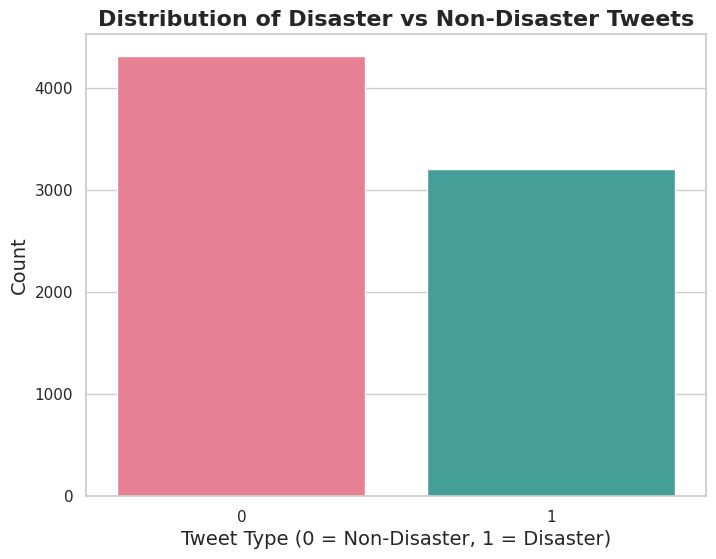

In [55]:
# Import the required library for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set(style='whitegrid')

# Plot label distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='target', data=train_data, palette='husl', hue='target', legend=False)

# Customize the title and labels
plt.title('Distribution of Disaster vs Non-Disaster Tweets', fontsize=16, fontweight='bold')
plt.xlabel('Tweet Type (0 = Non-Disaster, 1 = Disaster)', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Show the plot
plt.show()

# #The above shows that the data is imbalanced, one of the reasons why F1 score is used for evaluation

# Tweet Length Analysis

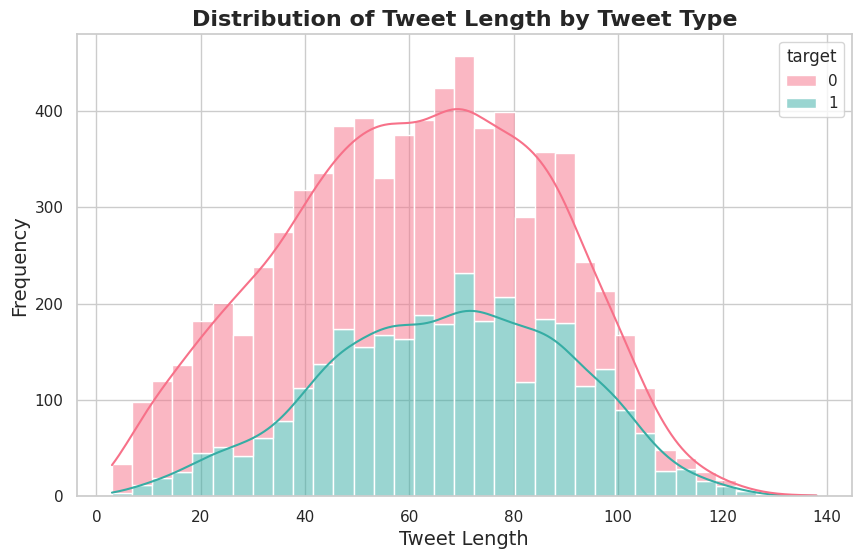

In [60]:
# Copy the dataframe to avoid changing the original one
train_data_copy = train_data.copy()

# Calculate the length of each tweets
train_data_copy['Tweet_length'] = train_data_copy['clean_text'].str.len()

# Set plot style
sns.set(style='whitegrid')

# Create a figure and plot the distribution of tweet lengths
plt.figure(figsize=(10, 6))

# Plot the distribution of tweet lengths for 0 and 1
sns.histplot(data=train_data_copy, x='Tweet_length', hue='target', multiple='stack', palette='husl', kde=True)

# Customize the title and label
plt.xlabel('Tweet Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Tweet Length by Tweet Type', fontsize=16, fontweight='bold')

# Show the plot
plt.show()


# Word Clouds

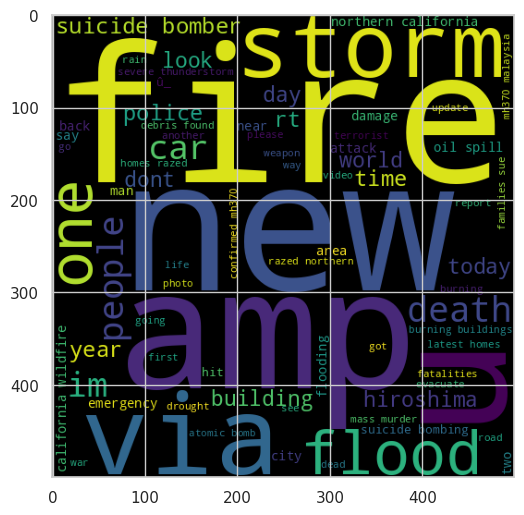

In [70]:
#Create a word cloud for Disaster Tweets

#import wordcloud library
from wordcloud import WordCloud

wordcloud = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'black')
spam_wordcloud = wordcloud.generate(train_data[train_data['target'] == 1]['clean_text'].str.cat(sep = " "))
plt.figure(figsize = (14,6))
plt.imshow(spam_wordcloud)
plt.show()

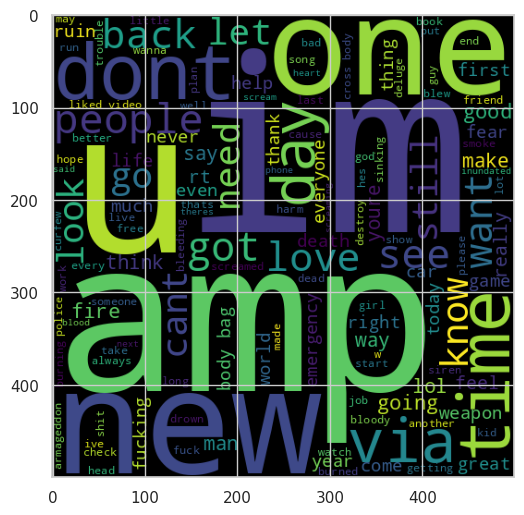

In [71]:
#Create a word cloud for Non-disaster tweets

wordcloud = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'black')
ham_wordcloud = wordcloud.generate(train_data[train_data['target'] == 0]['clean_text'].str.cat(sep = " "))
plt.figure(figsize = (14,6))
plt.imshow(ham_wordcloud)
plt.show()

# Model Building and Training

In [63]:
from sklearn.model_selection import train_test_split  # To split data into training and testing sets
#Train-test split
X = train_data['clean_text']
y = train_data['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=3000)

# Transform the training and testing data
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

In [65]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Neural Network': MLPClassifier(),
    'Extra Trees Classifier': ExtraTreesClassifier(),
    'Passive Aggressive Classifier': PassiveAggressiveClassifier()


}

In [66]:
# Train each model and store the predictions
predictions = {}
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    predictions[name] = model.predict(X_val_tfidf)

In [68]:
# Make predictions for each model
predictions = {}
for name, model in models.items():
    predictions[name] = model.predict(X_val_tfidf)

# Model Evaluation

In [69]:
# Evaluate each model by displaying f1 score
from sklearn.metrics import f1_score

# Collect accuracy scores and classification reports
results = {}
for name, y_pred in predictions.items():
    f1 = f1_score(y_val, y_pred)

    results[name] = {
        'f1_score': f1
    }


# Display results
for name, result in results.items():
    print(f"Model: {name}")
    print(f"f1_score: {result['f1_score']:.4f}")
    print(classification_report(y_val, y_pred))
    print(' ')



Model: Logistic Regression
f1_score: 0.7549
              precision    recall  f1-score   support

           0       0.77      0.74      0.75       870
           1       0.66      0.69      0.68       635

    accuracy                           0.72      1505
   macro avg       0.71      0.72      0.71      1505
weighted avg       0.72      0.72      0.72      1505

 
Model: Naive Bayes
f1_score: 0.7517
              precision    recall  f1-score   support

           0       0.77      0.74      0.75       870
           1       0.66      0.69      0.68       635

    accuracy                           0.72      1505
   macro avg       0.71      0.72      0.71      1505
weighted avg       0.72      0.72      0.72      1505

 
Model: Random Forest
f1_score: 0.7335
              precision    recall  f1-score   support

           0       0.77      0.74      0.75       870
           1       0.66      0.69      0.68       635

    accuracy                           0.72      1505
   mac

# Train with the best Model

In [72]:
#Train the best model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

LogisticRegression()

#  Submission

In [73]:
#Prepare submission
test_data['clean_text'] = test_data['text'].apply(preprocess_text)
test_vec = tfidf.transform(test_data['clean_text'])
test_pred = model.predict(test_vec)

In [76]:
#submission file
submission = pd.DataFrame({'id': test_data['id'], 'target': test_pred})
submission.to_csv('submission.csv', index=False)